In [1]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import networkx as nx
import osmnx as ox
import geopandas as gpd
import networkx as nx

/Users/oliver.jones/.local/share/virtualenvs/streamlit-wkv603WK/lib/python3.10/site-packages/geopandas/_compat.py:123: UserWarning: The Shapely GEOS version (3.10.3-CAPI-1.16.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


In [3]:
#load in the hospital sites data to be used to score potential viable locations
hospitals = pd.read_csv('../data/cambridge_uni_hospital_sites.csv')
hospitals.head(2)

,Code,Name,National Grouping,High Level Health Geography,Address Line 1,Address Line 2,Address Line 3,Address Line 4,Address Line 5,Postcode,Open Date,Close Date,Organisation Sub-Type Code,Parent Org Code
0,A6B3B,CUH AT MEADOWS COMMUNITY CENTRE,Y61,QUE,1 ST. CATHARINES ROAD,NaN,NaN,CAMBRIDGE,NaN,CB4 3XJ,20211001,NaN,NaN,RGT
1,A9J5N,CUH AT ROSMINI CENTRE,Y61,QUE,69A QUEENS ROAD,NaN,NaN,WISBECH,NaN,PE13 2PH,20220401,NaN,NaN,RGT


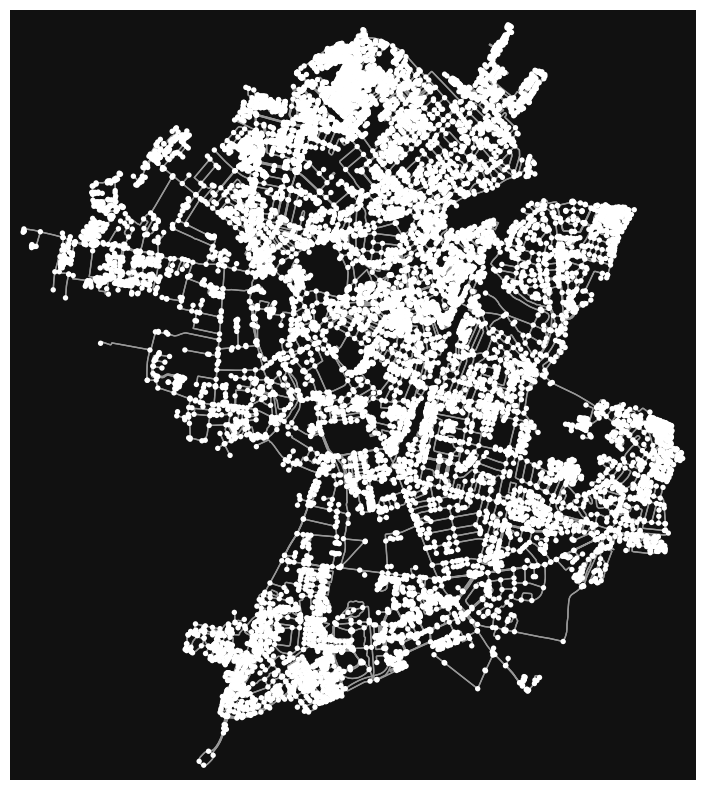

In [4]:

G = ox.graph.graph_from_place('Cambridge', simplify = True, network_type = 'walk')

# The following code can be run to decrease the time required to generate OSMnx network graphs.
# If a node cannot access at least 10% of other nodes it is removed from the network
#---------------------------------------------------------------------------------------

'''
remove_list = []
num_nodes = len(G.nodes)
for node in G.nodes:  
     reach = len(nx.descendants(G, node))
     if reach < num_nodes / 10:
         remove_list.append(node)
for node in remove_list:
     G.remove_node(node)
'''
#---------------------------------------------------------------------------------------
ox.plot_graph(G, figsize = (10,10));

In [5]:
nodes, edges = ox.graph_to_gdfs(G)
nodes

,y,x,highway,street_count,ref,geometry
osmid,,,,,,
104521,52.203550,0.123491,traffic_signals,3,NaN,POINT (0.12349 52.20355)
104522,52.204039,0.123043,NaN,3,NaN,POINT (0.12304 52.20404)
104523,52.205293,0.121804,NaN,3,NaN,POINT (0.12180 52.20529)
104524,52.205374,0.121364,NaN,3,NaN,POINT (0.12136 52.20537)
104525,52.206162,0.120605,NaN,3,NaN,POINT (0.12061 52.20616)
...,...,...,...,...,...,...
10564763741,52.174922,0.138307,NaN,1,NaN,POINT (0.13831 52.17492)
10569007912,52.210312,0.111860,NaN,3,NaN,POINT (0.11186 52.21031)
10569007915,52.210347,0.111937,NaN,3,NaN,POINT (0.11194 52.21035)


In [6]:
#get the target addresses from the hospitals dataframe
target_index1 = 176
target_index2 = 173

target_address1 = hospitals['Address Line 1'][target_index1] + ', Cambridge'
target_address2 = hospitals['Address Line 1'][target_index2] + ', Cambridge'

#convert the addresses to lat long coordinates and get the nearest node on the graph
target_coords1 = ox.geocode(target_address1)
target_node1 = ox.nearest_nodes(G, target_coords1[1],target_coords1[0])

target_coords2 = ox.geocode(target_address2)
target_node2 = ox.nearest_nodes(G, target_coords2[1],target_coords2[0])

list_of_target_nodes = [target_node1, target_node2]

In [7]:
list_of_target_nodes[0]

2943568221

In [8]:
#generate the random sample of 100 samples by first removing the target node location from the dataframe
nodes_df = nodes.copy()
nodes_df = nodes_df[~nodes_df.index.isin(list_of_target_nodes)] #get the dataframe of nodes that do not have any target nodes in them
nodes_sample = nodes_df[['y', 'x']].sample(n = 100, random_state = 1234)
nodes_sample

,y,x
osmid,,
21591575,52.224083,0.110663
1488979824,52.199490,0.113681
7707784800,52.176200,0.135117
1547531121,52.233888,0.125579
1543118505,52.234267,0.133423
...,...,...
4772911473,52.172127,0.142657
1646109591,52.189417,0.130900
3268544973,52.214275,0.151990


In [9]:
#creating a function to calculate a score from a list of lengths calculated from the target node to each of the 100 sample nodes
def create_score(list_of_lengths):
    score = 1000
    for l in list_of_lengths:
        deduction = (((l/1000)/4.5)*60) * 5 #get the length in km divide by speed 4.5 km/h then divide by 60 to get time in minutes
        score = score - deduction #decrement the score by the derivation of time taken to each of the 100 nodes
        return score

In [10]:
#define a function to calculate multiple shortest route lengths from the target node to each of the 100 sample nodes
def create_list_of_lengths(nodes_sample, target_node):
    list_of_lengths = []
    for node in nodes_sample.index:
        length = nx.shortest_path_length(G, source=node, target=target_node, weight='length') #calculate route from target node to sample node
        list_of_lengths.append(length) #append the length to the list
    
    return list_of_lengths
    

In [11]:
#run the function defined above to generate a list of lengths between the target nodes and sample nodes
#then generate the score for each and store them in a dictionary
target_scores = {}
target_scores['Site 1'] = create_score(create_list_of_lengths(nodes_sample, list_of_target_nodes[0]))
target_scores['Site 2'] = create_score(create_list_of_lengths(nodes_sample, list_of_target_nodes[1]))
target_scores

{'Site 1': 534.4081333333332, 'Site 2': 703.1283999999999}

In [12]:
#print the scores for each proposed target site
print('The score for Site 1: {} is {}'.format(hospitals['Name'].iloc[target_index1], target_scores['Site 1']))
print('The score for Site 2: {} is {}'.format(hospitals['Name'].iloc[target_index2], target_scores['Site 2']))

The score for Site 1: CUH AT ROYAL PAPWORTH HOSPITAL is 534.4081333333332
The score for Site 2: NUFFIELD HEALTH CAMBRIDGE HOSPITAL is 703.1283999999999


In [13]:
#initiate dictionary to store routes for all 100 nodes for each proposed site
target_to_nodes_routes = {}
target_node_names = ['Site1', 'Site2']

In [14]:
#generate multiple shortest routes for each site and store in dictionary for plotting
for site, target_node in zip(target_node_names, list_of_target_nodes):
    list_of_routes = []
    for node in nodes_sample.index:
        route = nx.shortest_path(G, source=node, target=target_node, weight='length') #calculate route from target node to sample node
        list_of_routes.append(route) #append the length to the list
    target_to_nodes_routes[site] = list_of_routes
    


In [15]:
import folium

In [16]:
route_map = ox.plot_route_folium(G, target_to_nodes_routes[site][0], route_color = '#ff0000', opacity = 0.5)
for route in target_to_nodes_routes[site][1:len(target_to_nodes_routes[site])]:
    route_map = ox.plot_route_folium(G, route, route_map = route_map, route_color = '#ff0000', opacity = 0.5)
iframe = folium.IFrame('<font face = "Arial"><b>{}:</b> {}. <br><br><b>{} Score:</b> {}</br></br></font>'.format(site, target_address1, site, target_scores['Site 1']))
popup = folium.Popup(iframe, min_width=200, max_width=200)
folium.Marker(location=target_coords1,
popup = popup).add_to(route_map)

In [ ]:
m = folium.Map(location=target_coords2,tiles="cartodbpositron",zoom_start=13)

# layers to toggle
layer1 = folium.FeatureGroup(name='Route 1')
layer2 = folium.FeatureGroup(name='Route 2')
# create the route layers and add them to the map
route1 = [] 
for route in target_to_nodes_routes['Site1']:
    route_coords = []
    for node in route:
        route_coords.append((nodes.at[node, 'y'], nodes.at[node, 'x']))
        route1.append(route_coords)

route2 = []
for route in target_to_nodes_routes['Site2']:
    route_coords = []
    for node in route:
        route_coords.append((nodes.at[node, 'y'], nodes.at[node, 'x']))
        route2.append(route_coords)

folium.PolyLine(route1, color='red', weight=2, opacity=0.5).add_to(layer1)
folium.PolyLine(route2, color='green', weight=2, opacity=0.5).add_to(layer2)

# add the layers to the map
layer1.add_to(m)
layer2.add_to(m)

# add a layer control to toggle the layers on and off
folium.LayerControl().add_to(m)

# add a checkbox to toggle the layers on and off
folium.map.Marker(
[target_coords1[0], target_coords1[1]],
icon=folium.Icon(color='red', icon='info-sign')
).add_to(layer1)

folium.map.Marker(
[target_coords2[0], target_coords2[1]],
icon=folium.Icon(color='green', icon='info-sign')
).add_to(layer2)

site1_marker = folium.map.Marker(
[target_coords1[0], target_coords1[1]],
icon=folium.Icon(color='red', icon='info-sign')
).add_to(layer1)
site1_popup = folium.Popup('<b>Site 1:</b>: {}<br><b>Score:</b> {}'.format(target_address1,target_scores['Site 1']), max_width=250)
popup = folium.Popup(iframe, min_width=200, max_width=200)
site1_marker.add_child(site1_popup)
# add a marker and popup for each site
site2_marker = folium.map.Marker(
[target_coords2[0], target_coords2[1]],
icon=folium.Icon(color='green', icon='info-sign')
).add_to(layer2)
site2_popup = folium.Popup('<b>Site 2:</b> {}<br><b>Score:</b> {}'.format(target_address2,target_scores['Site 2']), max_width=250)
site2_marker.add_child(site2_popup)


In [19]:
m.save('oj_map.html')